In [10]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [11]:
if __name__ == '__main__':
    pic_path = 'D:\cvcv\lenna.png' 
    img = plt.imread(pic_path)
    print("image",img)
    if pic_path[-4:] == '.png':  # .png图片在这里的存储格式是0到1的浮点数，所以要扩展到255再计算
        img = img * 255  # 还是浮点数类型
    img = img.mean(axis=-1)  # 取均值的方法进行灰度化

image [[[0.8862745  0.5372549  0.49019608]
  [0.8862745  0.5372549  0.49019608]
  [0.8745098  0.5372549  0.52156866]
  ...
  [0.9019608  0.5803922  0.47843137]
  [0.8666667  0.50980395 0.43137255]
  [0.78431374 0.3882353  0.3529412 ]]

 [[0.8862745  0.5372549  0.49019608]
  [0.8862745  0.5372549  0.49019608]
  [0.8745098  0.5372549  0.52156866]
  ...
  [0.9019608  0.5803922  0.47843137]
  [0.8666667  0.50980395 0.43137255]
  [0.78431374 0.3882353  0.3529412 ]]

 [[0.8862745  0.5372549  0.49019608]
  [0.8862745  0.5372549  0.49019608]
  [0.8745098  0.5372549  0.52156866]
  ...
  [0.9019608  0.5803922  0.47843137]
  [0.8666667  0.50980395 0.43137255]
  [0.78431374 0.3882353  0.3529412 ]]

 ...

 [[0.32941177 0.07058824 0.23529412]
  [0.32941177 0.07058824 0.23529412]
  [0.36078432 0.10588235 0.22745098]
  ...
  [0.6784314  0.28627452 0.32941177]
  [0.6745098  0.26666668 0.29803923]
  [0.69411767 0.24313726 0.30980393]]

 [[0.32156864 0.08627451 0.22352941]
  [0.32156864 0.08627451 0.2235

(-0.5, 511.5, 511.5, -0.5)

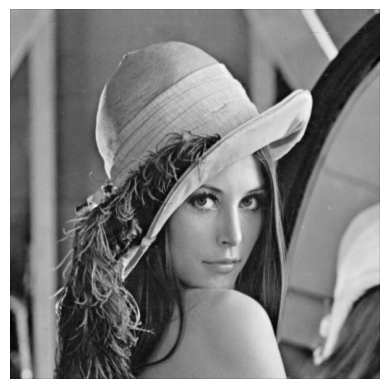

In [12]:
# 1、高斯平滑
#sigma = 1.52  # 高斯平滑时的高斯核参数，标准差，可调
sigma = 0.5  # 高斯平滑时的高斯核参数，标准差，可调
dim = 5  # 高斯核尺寸
Gaussian_filter = np.zeros([dim, dim])  # 存储高斯核，这是数组不是列表了
tmp = [i-dim//2 for i in range(dim)]  # 生成一个序列 
n1 = 1/(2*math.pi*sigma**2)  # 计算高斯核
n2 = -1/(2*sigma**2)
for i in range(dim):
    for j in range(dim):
         Gaussian_filter[i, j] = n1*math.exp(n2*(tmp[i]**2+tmp[j]**2))
Gaussian_filter = Gaussian_filter / Gaussian_filter.sum()
dx, dy = img.shape
img_new = np.zeros(img.shape)  # 存储平滑之后的图像，zeros函数得到的是浮点型数据
tmp = dim//2
img_pad = np.pad(img, ((tmp, tmp), (tmp, tmp)), 'constant')  # 边缘填补
for i in range(dx):
     for j in range(dy):
        img_new[i, j] = np.sum(img_pad[i:i+dim, j:j+dim]*Gaussian_filter)
plt.figure(1)
plt.imshow(img_new.astype(np.uint8), cmap='gray')  # 此时的img_new是255的浮点型数据，强制类型转换才可以，gray灰阶
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

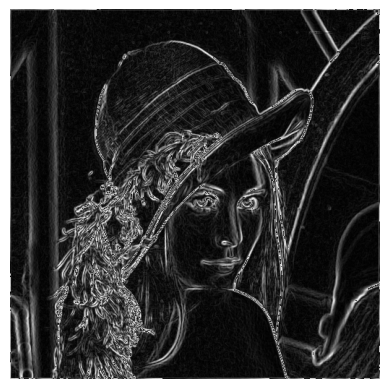

In [13]:
# 2、求梯度。以下两个是滤波用的sobel矩阵（检测图像中的水平、垂直和对角边缘）
sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
img_tidu_x = np.zeros(img_new.shape)  # 存储梯度图像
img_tidu_y = np.zeros([dx, dy])
img_tidu = np.zeros(img_new.shape)
img_pad = np.pad(img_new, ((1, 1), (1, 1)), 'constant')  # 边缘填补，根据上面矩阵结构所以写1
for i in range(dx):
    for j in range(dy):
        img_tidu_x[i, j] = np.sum(img_pad[i:i+3, j:j+3]*sobel_kernel_x)  # x方向
        img_tidu_y[i, j] = np.sum(img_pad[i:i+3, j:j+3]*sobel_kernel_y)  # y方向
        img_tidu[i, j] = np.sqrt(img_tidu_x[i, j]**2 + img_tidu_y[i, j]**2)
img_tidu_x[img_tidu_x == 0] = 0.00000001
angle = img_tidu_y/img_tidu_x
plt.figure(2)
plt.imshow(img_tidu.astype(np.uint8), cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

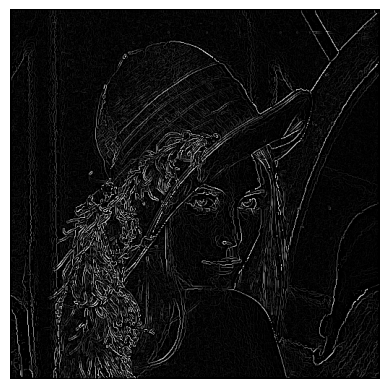

In [14]:
# 3、非极大值抑制
img_yizhi = np.zeros(img_tidu.shape)
for i in range(1, dx-1):
    for j in range(1, dy-1):
        flag = True  # 在8邻域内是否要抹去做个标记
        temp = img_tidu[i-1:i+2, j-1:j+2]  # 梯度幅值的8邻域矩阵
        if angle[i, j] <= -1:  # 使用线性插值法判断抑制与否
            num_1 = (temp[0, 1] - temp[0, 0]) / angle[i, j] + temp[0, 1]
            num_2 = (temp[2, 1] - temp[2, 2]) / angle[i, j] + temp[2, 1]
            if not (img_tidu[i, j] > num_1 and img_tidu[i, j] > num_2):
                flag = False
        elif angle[i, j] >= 1:
            num_1 = (temp[0, 2] - temp[0, 1]) / angle[i, j] + temp[0, 1]
            num_2 = (temp[2, 0] - temp[2, 1]) / angle[i, j] + temp[2, 1]
            if not (img_tidu[i, j] > num_1 and img_tidu[i, j] > num_2):
                flag = False
        elif angle[i, j] > 0:
            num_1 = (temp[0, 2] - temp[1, 2]) * angle[i, j] + temp[1, 2]
            num_2 = (temp[2, 0] - temp[1, 0]) * angle[i, j] + temp[1, 0]
            if not (img_tidu[i, j] > num_1 and img_tidu[i, j] > num_2):
                flag = False
        elif angle[i, j] < 0:
            num_1 = (temp[1, 0] - temp[0, 0]) * angle[i, j] + temp[1, 0]
            num_2 = (temp[1, 2] - temp[2, 2]) * angle[i, j] + temp[1, 2]
            if not (img_tidu[i, j] > num_1 and img_tidu[i, j] > num_2):
                flag = False
        if flag:
            img_yizhi[i, j] = img_tidu[i, j]
plt.figure(3)
plt.imshow(img_yizhi.astype(np.uint8), cmap='gray')
plt.axis('off')

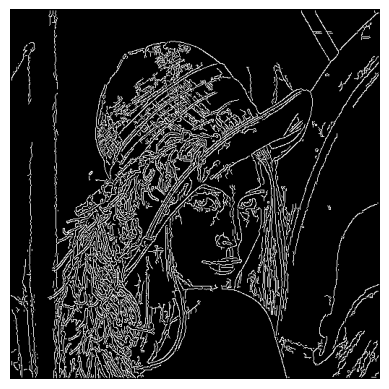

In [16]:
# 4、双阈值检测，连接边缘。遍历所有一定是边的点,查看8邻域是否存在有可能是边的点，进栈
lower_boundary = img_tidu.mean() * 0.5
high_boundary = lower_boundary * 3  # 这里我设置高阈值是低阈值的三倍
zhan = []
for i in range(1, img_yizhi.shape[0]-1):  # 外圈不考虑了
    for j in range(1, img_yizhi.shape[1]-1):
        if img_yizhi[i, j] >= high_boundary:  # 取，一定是边的点
            img_yizhi[i, j] = 255
            zhan.append([i, j])
        elif img_yizhi[i, j] <= lower_boundary:  # 舍
            img_yizhi[i, j] = 0
 
while not len(zhan) == 0:
    temp_1, temp_2 = zhan.pop()  # 出栈
    a = img_yizhi[temp_1-1:temp_1+2, temp_2-1:temp_2+2]
    if (a[0, 0] < high_boundary) and (a[0, 0] > lower_boundary):
        img_yizhi[temp_1-1, temp_2-1] = 255  # 这个像素点标记为边缘
        zhan.append([temp_1-1, temp_2-1])  # 进栈
    if (a[0, 1] < high_boundary) and (a[0, 1] > lower_boundary):
        img_yizhi[temp_1 - 1, temp_2] = 255
        zhan.append([temp_1 - 1, temp_2])
    if (a[0, 2] < high_boundary) and (a[0, 2] > lower_boundary):
        img_yizhi[temp_1 - 1, temp_2 + 1] = 255
        zhan.append([temp_1 - 1, temp_2 + 1])
    if (a[1, 0] < high_boundary) and (a[1, 0] > lower_boundary):
        img_yizhi[temp_1, temp_2 - 1] = 255
        zhan.append([temp_1, temp_2 - 1])
    if (a[1, 2] < high_boundary) and (a[1, 2] > lower_boundary):
        img_yizhi[temp_1, temp_2 + 1] = 255
        zhan.append([temp_1, temp_2 + 1])
    if (a[2, 0] < high_boundary) and (a[2, 0] > lower_boundary):
        img_yizhi[temp_1 + 1, temp_2 - 1] = 255
        zhan.append([temp_1 + 1, temp_2 - 1])
    if (a[2, 1] < high_boundary) and (a[2, 1] > lower_boundary):
        img_yizhi[temp_1 + 1, temp_2] = 255
        zhan.append([temp_1 + 1, temp_2])
    if (a[2, 2] < high_boundary) and (a[2, 2] > lower_boundary):
        img_yizhi[temp_1 + 1, temp_2 + 1] = 255
        zhan.append([temp_1 + 1, temp_2 + 1])
 
for i in range(img_yizhi.shape[0]):
    for j in range(img_yizhi.shape[1]):
        if img_yizhi[i, j] != 0 and img_yizhi[i, j] != 255:
            img_yizhi[i, j] = 0
 
# 绘图]
plt.figure(4)
plt.imshow(img_yizhi.astype(np.uint8), cmap='gray')
plt.axis('off')  # 关闭坐标刻度值
plt.show()